<a href="https://colab.research.google.com/github/chaiminwoo0223/Deep-Learning/blob/main/25%20-%20Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Style Transfer

![alt text](https://bloglunit.files.wordpress.com/2017/04/e18489e185b3e1848fe185b3e18485e185b5e186abe18489e185a3e186ba-2017-05-16-e1848be185a9e18492e185ae-1-50-07.png)

- A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576)
- Pretrained ResNet50
- Reference below
- https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
- https://github.com/leongatys/PytorchNeuralStyleTransfer

# Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# Hyperparameter

In [2]:
content_layer_num = 1
image_size = 512
epoch = 5000

# Data
## 1.Data Download

In [3]:
!rm -r images

try:
  os.mkdir("images")
  os.mkdir("images/content")
  os.mkdir("images/style")
except:
  pass

!wget https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg -P images/content
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg -P images/style

--2023-06-02 06:55:50--  https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 406531 (397K) [image/jpeg]
Saving to: ‘images/content/Tuebingen_Neckarfront.jpg’

Tuebingen_Neckarfro 100%[===================>] 397.00K  --.-KB/s    in 0.08s   

2023-06-02 06:55:51 (4.99 MB/s) - ‘images/content/Tuebingen_Neckarfront.jpg’ saved [406531/406531]

--2023-06-02 06:55:51--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awai

## 2.Directory

In [4]:
content_dir = "./images/content/Tuebingen_Neckarfront.jpg"
style_dir = "./images/style/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

## 3.Pre-Processing Function
- 전처리 함수

In [5]:
# 이미 학습된 ResNet 모델이 이미지넷으로 학습된 모델이기 때문에, 이에 따라 정규화 한다.
def image_preprocess(img_dir):
    img = Image.open(img_dir)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], std=[1, 1, 1])
    ])
    img = transform(img).view((-1, 3, image_size, image_size))
    return img

## 4.Post-Processing Function
- 후처리 함수

In [6]:
# 정규화 된 상태로 연산을 진행하고, 다시 이미지화 해서 보기위해 뺐던 값들을 다시 더한다.
# 또한 이미지가 0에서 1사이의 값을 가지도록 한다.
def image_postprocess(tensor):
    transform = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], std=[1, 1, 1])
    img = transform(tensor.clone())
    img = img.clamp(0, 1)
    img = torch.transpose(img, 0, 1)
    img = torch.transpose(img, 1, 2)
    return img

# Model
## 1.Resnet

In [7]:
# 미리 학습된 resnet50를 사용한다.
resnet = models.resnet50(pretrained=True)

for name, module in resnet.named_children():
    print(name)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [8]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8])

    def forward(self, x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)
        return out_0, out_1, out_2, out_3, out_4, out_5

## 2.Gram Matrix Function

In [9]:
# 그람 행렬을 생성하는 클래스 및 함수를 정의한다.
# [batch,channel,height,width] -> [b,c,h*w]
# [b,c,h*w] x [b,h*w,c] = [b,c,c]
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1, 2))
        return G

## 3.Model On GPU

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
# 모델은 학습의 대상이 아니기 때문에, requires_grad를 False로 설정한다.
resnet = Resnet().to(device)

for param in resnet.parameters():
    param.requires_grad = False

## 4.Gram Matrix Loss

In [12]:
# 그람행렬 간의 손실을 계산하는 클래스 및 함수를 정의한다.
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

# Train
## 1.Prepare Images

In [13]:
# 콘텐츠 이미지, 스타일 이미지, 학습의 대상이 되는 이미지를 정의한다.
content = image_preprocess(content_dir).to(device)
style = image_preprocess(style_dir).to(device)
generated = content.clone().requires_grad_().to(device)
print(content.requires_grad, style.requires_grad, generated.requires_grad)

False False True


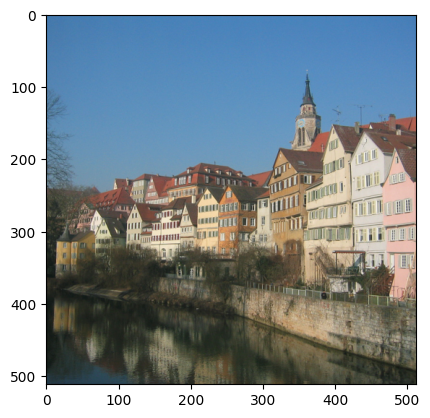

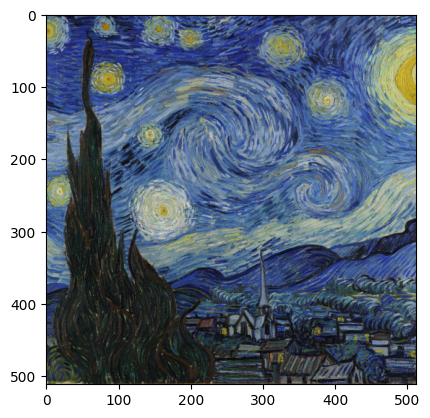

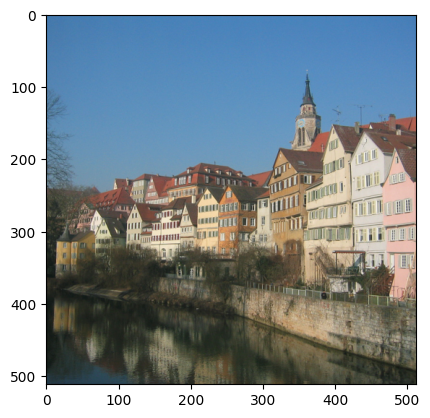

In [14]:
# 각각을 시각화한다.
plt.imshow(image_postprocess(content[0].cpu()))
plt.show()
plt.imshow(image_postprocess(style[0].cpu()))
plt.show()
gen_img = image_postprocess(generated[0].cpu()).data.numpy()
plt.imshow(gen_img)
plt.show()

## 2.Set Targets & Style Weights

In [15]:
# 목표값을 설정하고, 행렬의 크기에 따른 가중치도 함께 정의한다.
style_target = list(GramMatrix().to(device)(i) for i in resnet(style))
content_target = resnet(content)[content_layer_num]
style_weight = [1/n**2 for n in [64, 64, 256, 512, 1024, 2048]]

## 3.Train

In [16]:
# LBFGS 최적화 함수를 사용한다.
# 이때 학습의 대상은 모델의 가중치가 아닌 이미지 자체이다.
optimizer = optim.LBFGS([generated])
iteration = [0]

while iteration[0] < epoch:
    def closure():
        optimizer.zero_grad()
        out = resnet(generated)
        # 스타일 손실을 각각의 목표값에 따라 계산하고, 이를 리스트로 저장한다.
        style_loss = [GramMSELoss().to(device)(out[i], style_target[i])*style_weight[i] for i in range(len(style_target))]
        # 콘텐츠 손실은 지정한 위치에서만 계산되므로, 하나의 수치로 저장한다.
        content_loss = nn.MSELoss().to(device)(out[content_layer_num], content_target)
        # 스타일:콘텐츠 = 1000:1의 비중으로 총 손실을 계산한다.
        total_loss = 1000 * sum(style_loss) + torch.sum(content_loss)
        total_loss.backward()

        if iteration[0] % 100 == 0:
            print(total_loss)
        iteration[0] += 1
        return total_loss
    optimizer.step(closure)

tensor(1507037., device='cuda:0', grad_fn=<AddBackward0>)
tensor(44.0325, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.5512, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6769, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4103, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9187, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6619, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4080, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3445, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2990, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2644, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2385, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2186, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2030, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1895, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1793, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1704, device='cuda:0', grad_fn=<AddB

# Check Results

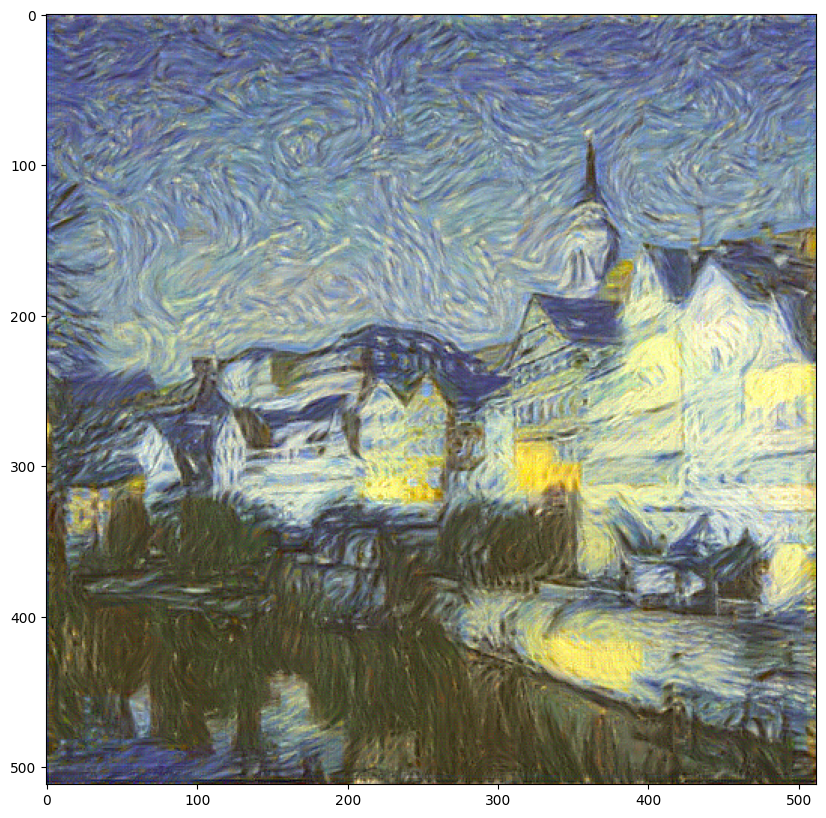

In [17]:
gen_img = image_postprocess(generated[0].cpu()).data.numpy()
plt.figure(figsize=(10, 10))
plt.imshow(gen_img)
plt.show()